In [1]:
data <- read.delim("View_CLI_BCK_CS_Anonimizado_TRN.txt",quote="")

# DATA PREPROCESSING

In [5]:
#check for duplicate rows
anyDuplicated.data.frame(data)

#convert DATETIME from factor to date
data$DATETIME <- as.Date(data$DATETIME, format = "%Y-%m-%d %H:%M:%S")

#convert LOJA to factor variable,extract top 31 store ids and set remaining ids to 'other'
data$LOJA <- factor(data$LOJA)
top_31 <- as.data.frame(sort(table(data$LOJA),decreasing=TRUE)[1:31])[,1]
levels(data$LOJA)[!(levels(data$LOJA) %in% top_31)] <- "OTHER"

#impute ages < 18 and > 100 to mean age value
mean_age <- with(data, mean(IDADE[IDADE >= 18 & IDADE <= 100]))
data <- transform(data, IDADE = ifelse(IDADE < 18 | IDADE > 100, floor(mean_age), IDADE))

#create age bins
data$age_bin<-cut(data$IDADE, c(18,24,34,44,54,64,74,84,999), include.lowest = TRUE,  labels=c("18-24","25-34","35-44","45-54","55-64","65-74","75-84","85+"))
data$age_bin <- factor(data$age_bin, ordered = TRUE)

#clean number of dependents variable
data <- transform(data, NUMERO_DE_DEPENDENTES = ifelse(NUMERO_DE_DEPENDENTES >= 20, floor(NUMERO_DE_DEPENDENTES/10), NUMERO_DE_DEPENDENTES))

#merge some levels for state of residence
top_states <- as.data.frame(sort(table(data$UF_RESIDENCIAL),decreasing=TRUE)[1:8])[,1]
levels(data$UF_RESIDENCIAL)[!(levels(data$UF_RESIDENCIAL) %in% top_states)] <- "OTHER"

#combine zip code variables into one var
data$zip_code <- data$CEP_DIGITO_1*1000 + data$CEP_DIGITO_2*100 + data$CEP_DIGITO_3*10 + data$CEP_DIGITO_4

#clean Credit Card Bills Due Date variable
data <- transform(data, DIA_VENCIMENTO = ifelse(DIA_VENCIMENTO > 30, 30, DIA_VENCIMENTO))

#tipo_residencia - assign " "(blanks) to 'O' (other) factor level
data$TIPO_RESIDENCIA[data$TIPO_RESIDENCIA == " "] <- 'O'
data$TIPO_RESIDENCIA <- factor(data$TIPO_RESIDENCIA)

#time in current residence. clean values, convert to years and bin
data <- transform(data, TEMPO_RESIDENCIA = ifelse(floor(TEMPO_RESIDENCIA/12) > IDADE, IDADE, TEMPO_RESIDENCIA/12))
data$time_in_residence<-cut(data$TEMPO_RESIDENCIA, c(0,1,3,6,10,20,30,999), include.lowest=TRUE, labels=c("0-1", "1-3", "3-6", "6-10", "10-20", "20-30", "30+"))
data$time_in_residence <- factor(data$time_in_residence, ordered = TRUE)

#time in current job (months). If this is > (Age-16)*12, set to (Age-16)*12
#change to years in current job and bin
data <- transform(data, TEMPO_EMPREGO = ifelse(TEMPO_EMPREGO > (IDADE-16)*12, (IDADE-16)*12, TEMPO_EMPREGO))
data$TEMPO_EMPREGO <- data$TEMPO_EMPREGO/12
data$job_tenure<-cut(data$TEMPO_EMPREGO, c(0,1,3,6,10,15,20,999), include.lowest=TRUE, labels=c("0-1", "1-3", "3-6", "6-10", "10-15", "15-20", "20+"))
data$job_tenure <- factor(data$job_tenure, ordered = TRUE)

#did the applicant provide a personal reference?
data$FLAG_PROVIDED_REFERENCE <- as.factor(ifelse(data$REFERENCIA_PESSOAL == "","N","S"))

#monthly income bins
data$RENDA_LIQUIDA <- data$RENDA_LIQUIDA/100
data <- transform(data, RENDA_LIQUIDA = ifelse(RENDA_LIQUIDA > 55200, 55200, RENDA_LIQUIDA))
data$monthly_income_bin<-cut(data$RENDA_LIQUIDA, c(0,500,750,1000,1500,2000,2500,5000,999999999999), include.lowest=TRUE, labels=c("0-500", "500-750", "750-1000", "1000-1500", "1500-2000", "2000-2500", "2500-5000", "5000+"))
data$monthly_income_bin <- factor(data$monthly_income_bin, ordered = TRUE)

#replace blanks
data$FLAG_CHEQUE_ESPECIAL[data$FLAG_CHEQUE_ESPECIAL == ""] <- 'N'
data$FLAG_CHEQUE_ESPECIAL <- factor(data$FLAG_CHEQUE_ESPECIAL)
data$FLAG_COMPROVANTE_RESIDENCIA[data$FLAG_COMPROVANTE_RESIDENCIA == ""] <- 'N'
data$FLAG_COMPROVANTE_RESIDENCIA <- factor(data$FLAG_COMPROVANTE_RESIDENCIA)
data$FLAG_IDENTIDADE[data$FLAG_IDENTIDADE == ""] <- 'N'
data$FLAG_IDENTIDADE <- factor(data$FLAG_IDENTIDADE)
data$FLAG_CPF[data$FLAG_CPF == ""] <- 'N'
data$FLAG_CPF <- factor(data$FLAG_CPF)
data$FLAG_EXPERIENCIA_CREDITO[data$FLAG_EXPERIENCIA_CREDITO == ""] <- 'N'
data$FLAG_EXPERIENCIA_CREDITO <- factor(data$FLAG_EXPERIENCIA_CREDITO)
levels(data$COMPROVANTE_RENDA)[levels(data$COMPROVANTE_RENDA)==""] <- "OTHER"

#calculate target label freq 
data$TARGET_LABEL <- factor(data$TARGET_LABEL)
table(data$TARGET_LABEL)/nrow(data)

#drop columns, convert others to factors
data$CEP_DIGITO_1 <- NULL
data$CEP_DIGITO_2 <- NULL
data$CEP_DIGITO_3 <- NULL
data$CEP_DIGITO_4 <- NULL
data$ID_CLIENT <- NULL
data$DDD_RESIDENCIAL <- factor(data$DDD_RESIDENCIAL)
data$NUM_CONTAS_BANCO <- factor(data$NUM_CONTAS_BANCO)
data$CODIGO_PROFISSAO <- factor(data$CODIGO_PROFISSAO)
data$zip_code <- factor(data$zip_code)


[1] 0


            A      C      O      P 
378191  18346  70248   9347 286834 


 OTHER     AT     CC     CT     DR     IR 
640350   2870  62353   4725  51693    975 


        0         1 
0.7268515 0.2731485 

# ANALYSIS

In [7]:
library(ggplot2)
library(scales)
options(jupyter.plot_mimetypes = 'image/png') #shows plots within the notebook

## Seasonality

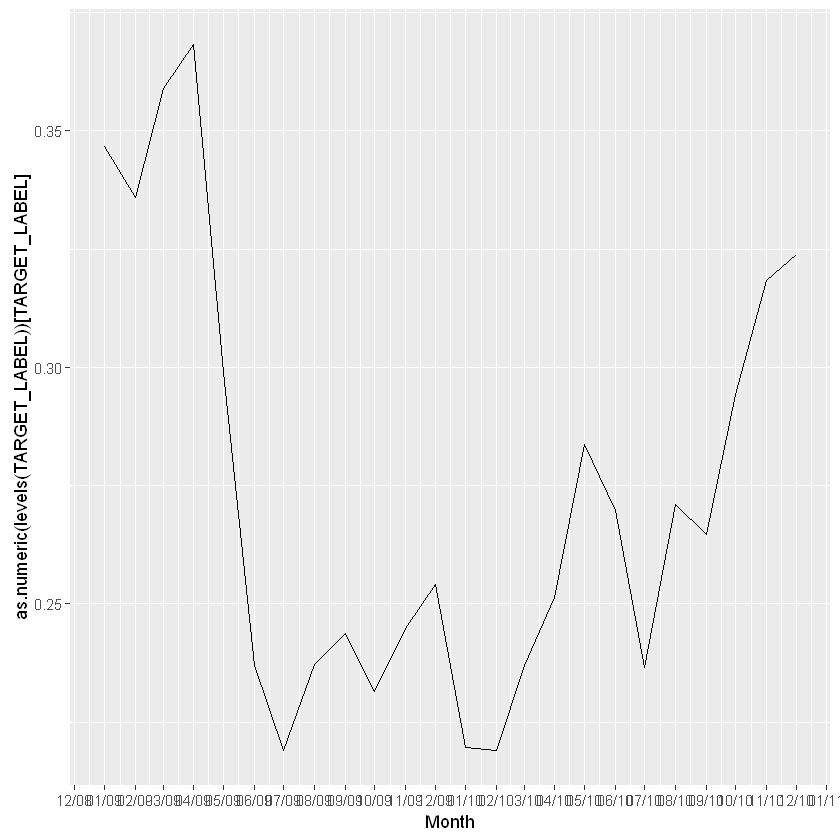

In [8]:
data$Month <- as.Date(cut(data$DATETIME,breaks = "month"))
data$Week <- as.Date(cut(data$DATETIME,breaks = "week",start.on.monday = TRUE))

ggplot(data = data,
       aes(Month, as.numeric(levels(TARGET_LABEL))[TARGET_LABEL])) +
  stat_summary(fun.y = mean, # adds up all observations for the week
               geom = "line") + # or "line"
  scale_x_date(
    labels = date_format("%m/%y"),
    breaks = date_breaks("1 month")) # custom x-axis labels

## Monthly Income

   
         0-500    500-750   750-1000  1000-1500  1500-2000  2000-2500
  0 0.69903999 0.69206950 0.73087977 0.81398825 0.87419323 0.92854114
  1 0.30096001 0.30793050 0.26912023 0.18601175 0.12580677 0.07145886
   
     2500-5000      5000+
  0 0.87274477 0.82585752
  1 0.12725523 0.17414248

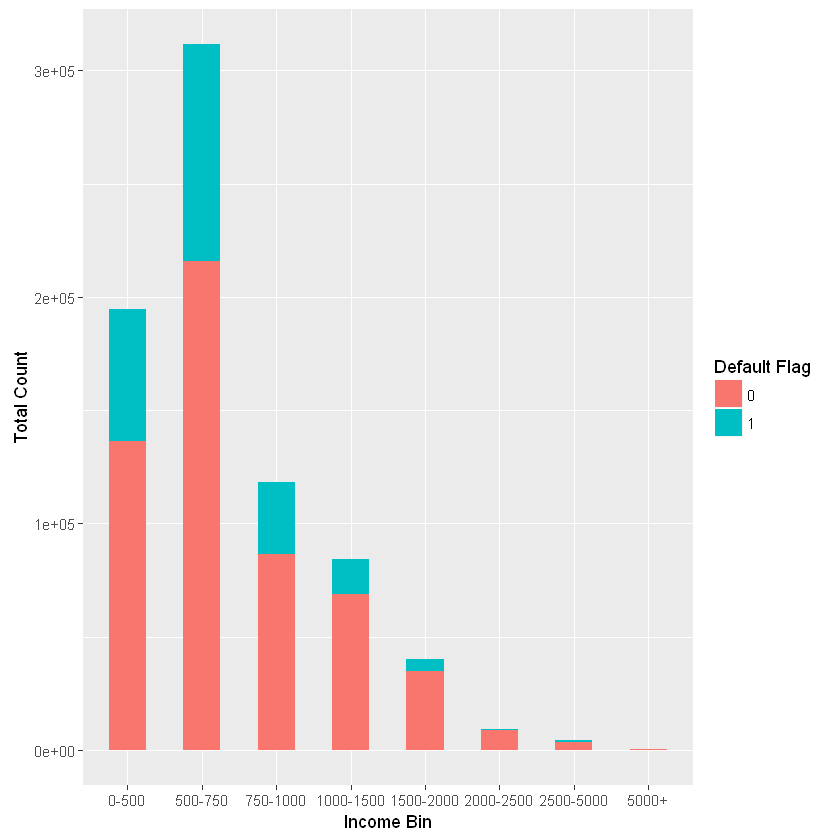

In [9]:
prop.table(table(data$TARGET_LABEL,data$monthly_income_bin),2)
ggplot(data, aes(x = monthly_income_bin, fill = TARGET_LABEL)) +
  stat_count(width=0.5) +
  xlab("Income Bin") +
  ylab("Total Count") +
  labs(fill = "Default Flag")

## Gender

   
            F         M
  0 0.7451682 0.6772038
  1 0.2548318 0.3227962

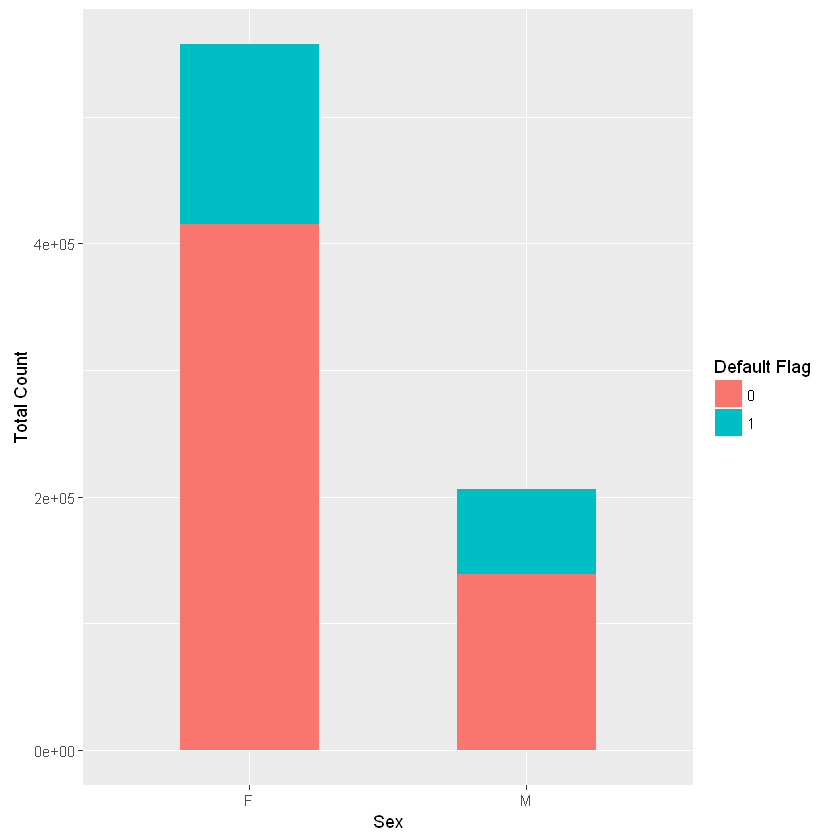

In [10]:
prop.table(table(data$TARGET_LABEL,data$SEXO),2)
ggplot(data, aes(x = SEXO, fill = TARGET_LABEL)) +
  stat_count(width=0.5) +
  xlab("Sex") +
  ylab("Total Count") +
  labs(fill = "Default Flag")

## Age

   
         18-24      25-34      35-44      45-54      55-64      65-74
  0 0.59772188 0.70023286 0.77299216 0.83304036 0.89288184 0.92745483
  1 0.40227812 0.29976714 0.22700784 0.16695964 0.10711816 0.07254517
   
         75-84        85+
  0 0.94335938 0.85669782
  1 0.05664062 0.14330218

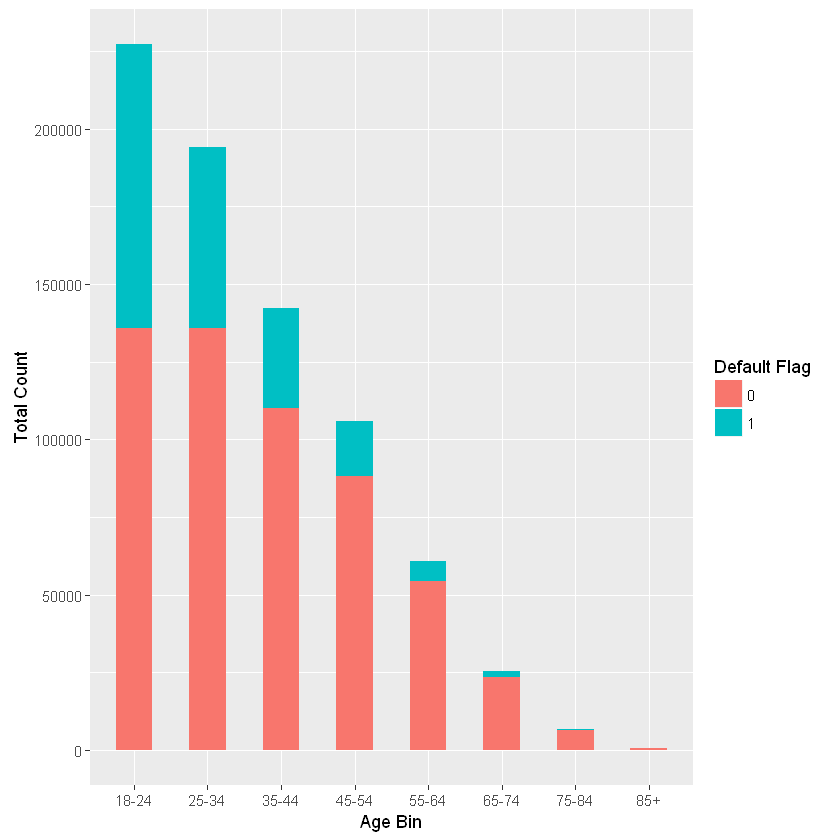

In [11]:
prop.table(table(data$TARGET_LABEL,data$age_bin),2)
ggplot(data, aes(x = age_bin, fill = TARGET_LABEL)) +
  stat_count(width=0.5) +
  xlab("Age Bin") +
  ylab("Total Count") +
  labs(fill = "Default Flag")

## Type of Residence
### A = Alugada (Rented)
### C = Com os pais (With Parents)
### O = Outro (Other)
### P = Propria (Own)

   
            A         C         O         P
  0 0.6752426 0.6191920 0.7519443 0.7226166
  1 0.3247574 0.3808080 0.2480557 0.2773834

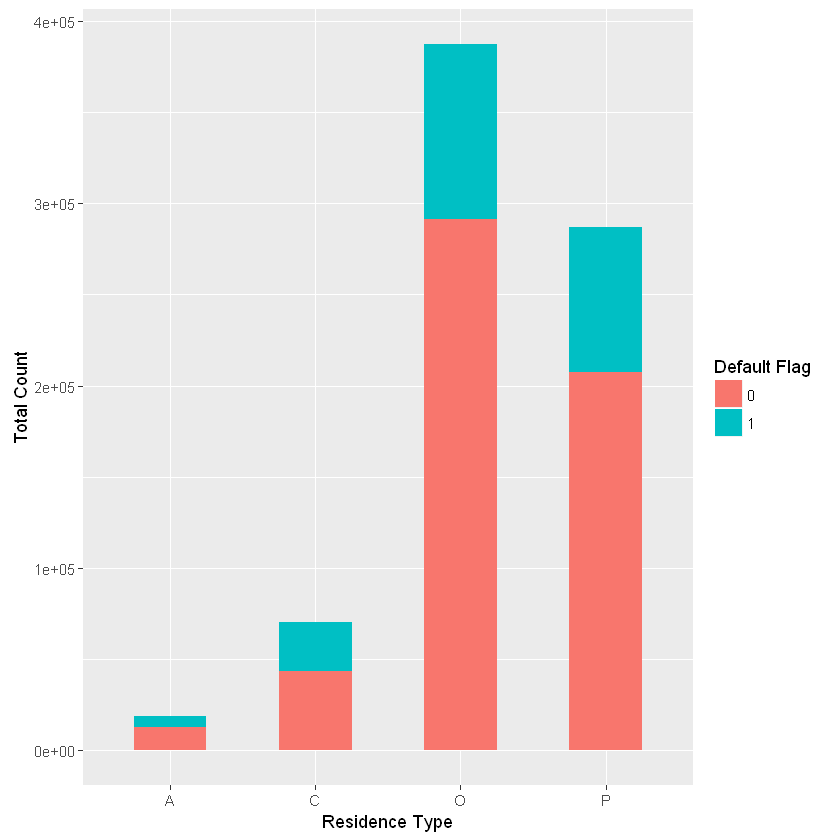

In [12]:
prop.table(table(data$TARGET_LABEL,data$TIPO_RESIDENCIA),2)
ggplot(data, aes(x = TIPO_RESIDENCIA, fill = TARGET_LABEL)) +
  stat_count(width=0.5) +
  xlab("Residence Type") +
  ylab("Total Count") +
  labs(fill = "Default Flag")

## State of Residence

   
        OTHER        AL        BA        ES        MG        PE        RJ
  0 0.8695369 0.6656979 0.7446220 0.7227396 0.7599189 0.6678185 0.7326899
  1 0.1304631 0.3343021 0.2553780 0.2772604 0.2400811 0.3321815 0.2673101
   
           RN        SE
  0 0.6249404 0.7282688
  1 0.3750596 0.2717312

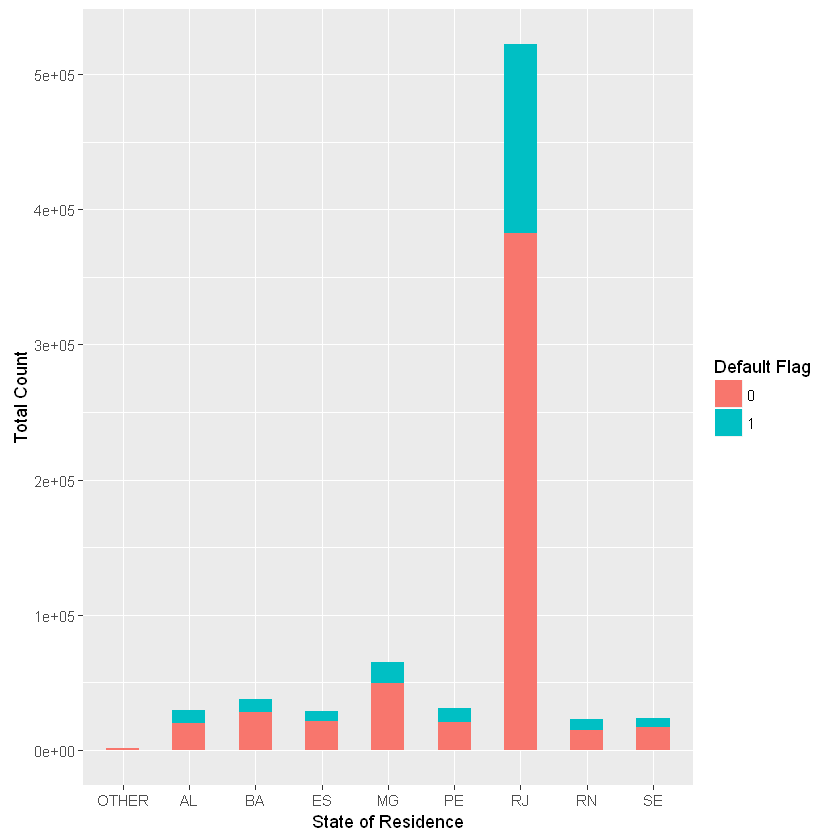

In [13]:
prop.table(table(data$TARGET_LABEL,data$UF_RESIDENCIAL),2)
ggplot(data, aes(x = UF_RESIDENCIAL, fill = TARGET_LABEL)) +
  stat_count(width=0.5) +
  xlab("State of Residence") +
  ylab("Total Count") +
  labs(fill = "Default Flag")

## Civil Status
### C = Casado (Married)
### D = Divorciado (Divorced)
### O = Outro (Other)
### S = Solteiro (Single)
### V = Viuvo (Widower)


   
            C         D         O         S         V
  0 0.8055523 0.8242778 0.6093544 0.6814958 0.8656440
  1 0.1944477 0.1757222 0.3906456 0.3185042 0.1343560

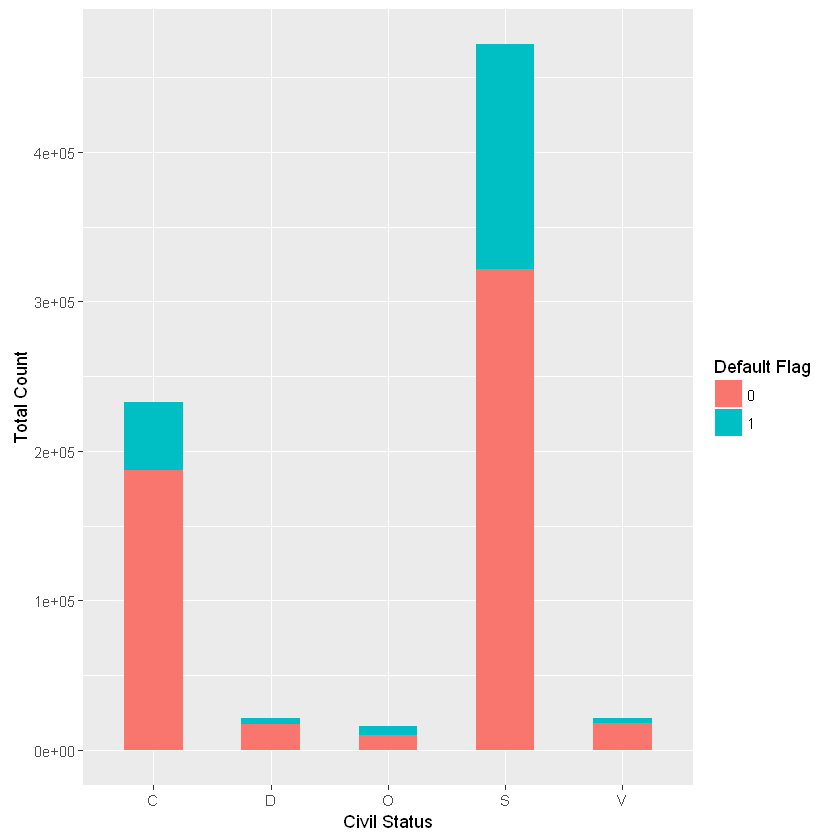

In [14]:
prop.table(table(data$TARGET_LABEL,data$ESTADO_CIVIL),2)
ggplot(data, aes(x = ESTADO_CIVIL, fill = TARGET_LABEL)) +
  stat_count(width=0.5) +
  xlab("Civil Status") +
  ylab("Total Count") +
  labs(fill = "Default Flag")

## JOB TENURE

   
          0-1       1-3       3-6      6-10     10-15     15-20       20+
  0 0.6650658 0.6721781 0.7554072 0.7982297 0.8377423 0.8556240 0.8876565
  1 0.3349342 0.3278219 0.2445928 0.2017703 0.1622577 0.1443760 0.1123435

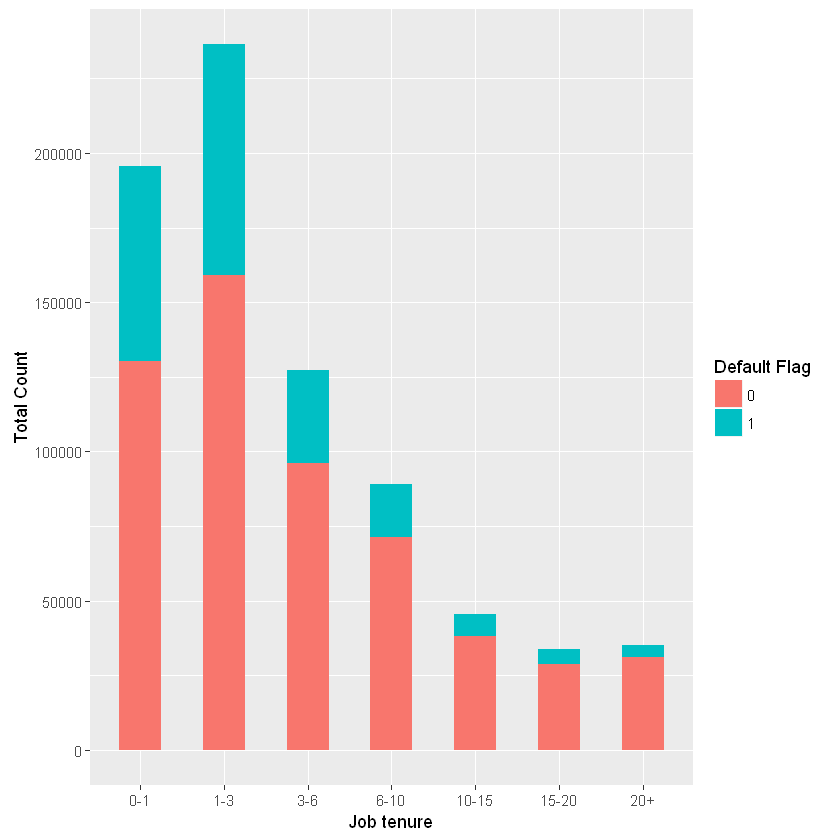

In [17]:
prop.table(table(data$TARGET_LABEL,data$job_tenure),2)
ggplot(data, aes(x = job_tenure, fill = TARGET_LABEL)) +
  stat_count(width=0.5) +
  xlab("Job tenure") +
  ylab("Total Count") +
  labs(fill = "Default Flag")

## Time in Residence

   
          0-1       1-3       3-6      6-10     10-20     20-30       30+
  0 0.7043896 0.7070225 0.7203493 0.7363583 0.6995993 0.7621686 0.8154435
  1 0.2956104 0.2929775 0.2796507 0.2636417 0.3004007 0.2378314 0.1845565

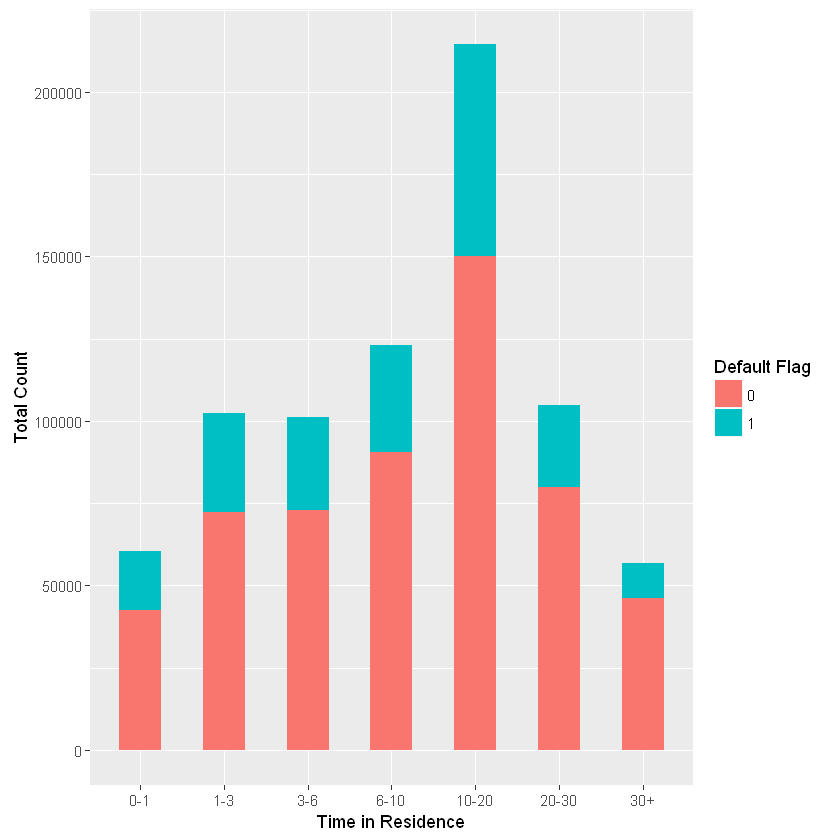

In [19]:
prop.table(table(data$TARGET_LABEL,data$time_in_residence),2)
ggplot(data, aes(x = time_in_residence, fill = TARGET_LABEL)) +
  stat_count(width=0.5) +
  xlab("Time in Residence") +
  ylab("Total Count") +
  labs(fill = "Default Flag")

## CORRELATION MATRIX

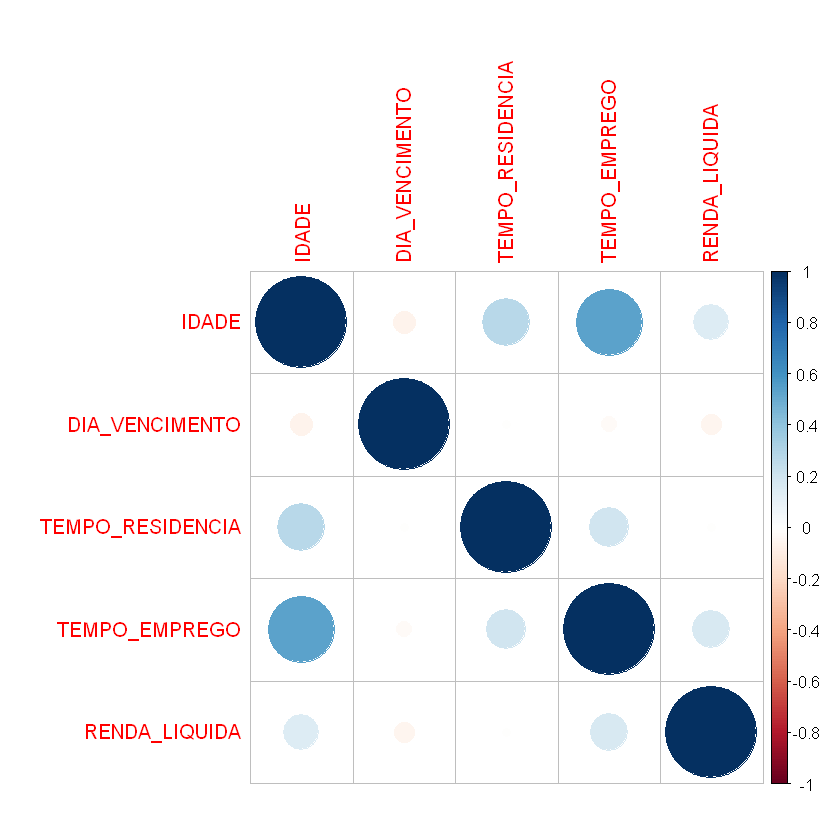

In [22]:
library(corrplot)
numeric_cols <- data[,sapply(data,is.numeric)]
M = cor(numeric_cols)
corrplot(M, method = "circle")

# LOGISTIC REGRESSION

In [24]:
logreg.1 <- glm(formula = TARGET_LABEL ~ SEXO +  ESTADO_CIVIL + IDADE + NUMERO_DE_DEPENDENTES + UF_RESIDENCIAL + DIA_VENCIMENTO
                + TIPO_RESIDENCIA + TEMPO_EMPREGO + TEMPO_RESIDENCIA + monthly_income_bin, 
                family = binomial(), data = data)

summary(logreg.1)


Call:
glm(formula = TARGET_LABEL ~ SEXO + ESTADO_CIVIL + IDADE + NUMERO_DE_DEPENDENTES + 
    UF_RESIDENCIAL + DIA_VENCIMENTO + TIPO_RESIDENCIA + TEMPO_EMPREGO + 
    TEMPO_RESIDENCIA + monthly_income_bin, family = binomial(), 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8856  -0.8614  -0.6026   1.2102   2.9403  

Coefficients:
                        Estimate Std. Error  z value Pr(>|z|)    
(Intercept)           -1.0371213  0.0831201  -12.477  < 2e-16 ***
SEXOM                  0.3566496  0.0059968   59.473  < 2e-16 ***
ESTADO_CIVILD          0.2380765  0.0193845   12.282  < 2e-16 ***
ESTADO_CIVILO          0.5327546  0.0179244   29.722  < 2e-16 ***
ESTADO_CIVILS          0.2822855  0.0068246   41.363  < 2e-16 ***
ESTADO_CIVILV          0.3189908  0.0219370   14.541  < 2e-16 ***
IDADE                 -0.0353876  0.0002852 -124.099  < 2e-16 ***
NUMERO_DE_DEPENDENTES  0.1101015  0.0077939   14.127  < 2e-16 ***
UF_RESIDENCIALAL       0.801436